# Customer Churn Analysis

This workbook is a code demo that implements a custom Customer Retention Analysis class that has a number of helpful functions to generate customer churn insights frequently used for marketing analytics to understand the growth and change of an organisation's customer base (new vs retained vs lost)

This workbook is accompanied by a blog article at "Analyzing Customer Retention Via Cohort Analysis" <https://medium.com/p/1f381748e555>

In [1]:
#Load the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.Creating The Custom Class

In [2]:
class CustRetAnalysisObj:
    def __init__(self, trx_dataframe,order_id,transaction_id,customer_id,timestamp,monetary_value,granularity="d"):
        self.trx_dataframe = trx_dataframe #input dataframe
        self.order_id = order_id #unique number for each order which may have multiple transactions within a single order
        self.transaction_id = transaction_id #unique number for each trx (i.e order line item) 
        self.customer_id = customer_id
        self.timestamp = timestamp #transaction timestamp
        self.monetary_value= monetary_value 
        self.granularity= granularity #D,W,M,MS,Q,QS,Y,YS

    def aggregate_by_time(self): #this function returns a dataframe aggregated by time granularity selected 
        df_monetary_value=self.trx_dataframe[[self.timestamp,self.customer_id,self.monetary_value]].groupby([
                     pd.Grouper(key=self.timestamp, axis=0,freq=self.granularity),
                     self.customer_id
                   ]).sum()
        df_monetary_value=df_monetary_value.reset_index()
        
        df_invoice_count=self.trx_dataframe[[self.timestamp,self.order_id,self.customer_id]].groupby([
                     pd.Grouper(key=self.timestamp, axis=0,freq=self.granularity),
                     self.customer_id
                   ]).nunique()
        df_invoice_count=df_invoice_count.reset_index()
    
        df_trxline_count=self.trx_dataframe[[self.timestamp,self.transaction_id,self.customer_id]].groupby([
                     pd.Grouper(key=self.timestamp, axis=0,freq=self.granularity),
                     self.customer_id
                   ]).count()
        df_trxline_count=df_trxline_count.reset_index()
    
        df=df_monetary_value.merge(df_invoice_count, on=[self.timestamp,self.customer_id])
        df=df.merge(df_trxline_count, on=[self.timestamp,self.customer_id])
    
        df=df.rename(columns = {self.order_id:'Unique Count Of '+self.order_id,self.transaction_id:'Count of '+self.transaction_id})
    
        return df

    def spend_by_period(self):
        return self.aggregate_by_time()[[self.timestamp,self.monetary_value]].groupby([self.timestamp]).sum()
        
    def new_joiner_by_period(self): #this function returns the no of new joiners by trx date against time granularity selected 
        customer_earliest_order_period=pd.DataFrame(self.aggregate_by_time().groupby([self.customer_id])[self.timestamp].min())
        customer_earliest_order_period.rename(columns = {self.timestamp:'CohortJoinPeriod'}, inplace = True)
        customer_earliest_order_period=customer_earliest_order_period.reset_index()

        customer_joining_by_period=pd.DataFrame(customer_earliest_order_period.groupby([
                         pd.Grouper(key='CohortJoinPeriod', axis=0, freq=self.granularity) #First Order Date/Time Period
                       ])[self.customer_id].count())
        
        customer_joining_by_period.rename(columns = {self.customer_id:"Total Count Of New Joiner "+self.customer_id}, inplace = True)
        
        return customer_joining_by_period

    def total_active_customers_by_period(self):
        data_agg_by_period=self.aggregate_by_time().merge(self.customer_by_earliest_and_latest_transaction(), on = self.customer_id, how = 'left')
        data_agg_by_period=data_agg_by_period.merge(self.cohort_time_step_mapping(), on =[self.timestamp,'CohortJoinPeriod'])
        
        #count monthly active customers from each cohort
        grouping = data_agg_by_period.groupby([self.timestamp,'CohortJoinPeriod','CohortTimeStep'])
        cohort_data = grouping[self.customer_id].apply(pd.Series.nunique)
        cohort_data = cohort_data.reset_index()
        TotalCountActiveCustomers=pd.DataFrame(cohort_data.groupby(self.timestamp)[self.customer_id].sum())
        TotalCountActiveCustomers.rename(columns = {self.customer_id:"Total Count Of Active "+self.customer_id}, inplace = True)

        NewJoinerCountCustomers=self.new_joiner_by_period()
        NewJoinerCountCustomers.index.names = [self.timestamp]
        NewJoinerCountCustomers.rename(columns = {self.customer_id:"Total Count Of New Joiner "+self.customer_id}, inplace = True)
        
        TotalCountActiveCustomer=TotalCountActiveCustomers.join(NewJoinerCountCustomers)
        
        TotalCountActiveCustomer["Total Count Of Retained "+self.customer_id]=(
            TotalCountActiveCustomer["Total Count Of Active "+self.customer_id]-
            TotalCountActiveCustomer["Total Count Of New Joiner "+self.customer_id])

        return TotalCountActiveCustomer

    def customer_by_earliest_and_latest_transaction(self): 
        customer_latest_order_period=pd.DataFrame(self.aggregate_by_time().groupby([self.customer_id])[self.timestamp].max())
        customer_latest_order_period.rename(columns = {self.timestamp:'Last Recent Order Period'}, inplace = True)
        customer_latest_order_period=customer_latest_order_period.reset_index()

        customer_earliest_order_period=pd.DataFrame(self.aggregate_by_time().groupby([self.customer_id])[self.timestamp].min())
        customer_earliest_order_period.rename(columns = {self.timestamp:'CohortJoinPeriod'}, inplace = True)
        customer_earliest_order_period=customer_earliest_order_period.reset_index()

        df_merge = customer_earliest_order_period.merge(customer_latest_order_period, on = self.customer_id, how = 'left')
        
        return df_merge

    def cohort_time_step_mapping(self):
        # Define the date range
        start_date = self.aggregate_by_time()[self.timestamp].min()
        end_date = self.aggregate_by_time()[self.timestamp].max()
        frequency = self.granularity 
        
        date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
        
        timesteps = pd.DataFrame(index=date_range)
        timesteps = timesteps.reset_index()
        timesteps = timesteps.reset_index()
        timesteps.columns = ['CohortTimeStep', self.timestamp]
        timestep_mapping=pd.DataFrame()
        
        for i in range(0,len(timesteps)):
            timestep_temp=timesteps.copy()
            timestep_temp["CohortJoinPeriod"]=timesteps[self.timestamp][i]
            timestep_temp["CohortTimeStep"]=timesteps["CohortTimeStep"]
            timestep_temp["CohortTimeStep"]=timestep_temp["CohortTimeStep"].shift(i)
            timestep_mapping=pd.concat([timestep_mapping, timestep_temp], 
                          ignore_index = True)

        return timestep_mapping

    def cohort_by_acquisition_period(self,selectedmode="pct"):

        data_agg_by_period=self.aggregate_by_time().merge(self.customer_by_earliest_and_latest_transaction(), on = self.customer_id, how = 'left')
        data_agg_by_period=data_agg_by_period.merge(self.cohort_time_step_mapping(), on =[self.timestamp,'CohortJoinPeriod'])

        #count monthly active customers from each cohort
        grouping = data_agg_by_period.groupby([self.timestamp,'CohortJoinPeriod','CohortTimeStep'])
        cohort_data = grouping[self.customer_id].apply(pd.Series.nunique)
        cohort_data = cohort_data.reset_index()
        cohort_counts = cohort_data.pivot_table(index='CohortJoinPeriod', columns = 'CohortTimeStep', values=self.customer_id)
        
        #Retention in percentages
        cohort_sizes = cohort_counts.iloc[:,0]
        retention = cohort_counts.divide(cohort_sizes, axis=0)
        retention = retention.round(2) * 100

        cohort_spend= grouping[self.monetary_value].apply(pd.Series.sum).reset_index().round().pivot_table(index='CohortJoinPeriod', columns = 'CohortTimeStep', values=self.monetary_value)

        if selectedmode=="pct":
            return retention
        elif selectedmode=="abs":
            return cohort_counts
        elif selectedmode=="spend":
            return cohort_spend
        elif selectedmode=="cohort_data":
            return cohort_data

    def overall_retention_by_timestep(self):
        OverallRetentionRate=pd.DataFrame(self.cohort_by_acquisition_period("abs").sum())
        OverallRetentionRate["Retention Rate %"]=round(OverallRetentionRate[0]/OverallRetentionRate[0].max()*100,2)
        OverallRetentionRate.rename(columns = {0:'Retained Customers By TimeStep'}, inplace = True)
        return OverallRetentionRate

    def cohort_by_customer_attr(self,df_customer_attr,customer_attr,selectedmode="pct"):

        data_agg_by_period=self.aggregate_by_time().merge(self.customer_by_earliest_and_latest_transaction(), on = self.customer_id, how = 'left')
        data_agg_by_period=data_agg_by_period.merge(self.cohort_time_step_mapping(), on =[self.timestamp,'CohortJoinPeriod'])
        data_agg_by_period=data_agg_by_period.merge(df_customer_attr, on =[self.customer_id])
        
        #count active customers from each criteria cohort
        grouping = data_agg_by_period.groupby([customer_attr,'CohortTimeStep'])
        cohort_data = grouping[self.customer_id].apply(pd.Series.nunique)
        cohort_data = cohort_data.reset_index()
        cohort_counts = cohort_data.pivot_table(index=customer_attr, columns = 'CohortTimeStep', values=self.customer_id)
        
        #Retention in percentages
        cohort_sizes = cohort_counts.iloc[:,0]
        retention = cohort_counts.divide(cohort_sizes, axis=0)
        retention = retention.round(2) * 100

        cohort_spend= grouping[self.monetary_value].apply(pd.Series.sum).reset_index().round().pivot_table(index=customer_attr, columns = 'CohortTimeStep', values=self.monetary_value)

        if selectedmode=="pct":
            return retention
        elif selectedmode=="abs":
            return cohort_counts
        elif selectedmode=="spend":
            return cohort_spend

    def cohort_by_acquisition_period_by_inactive_period(self,durationInDays,selectedmode="pct"):

        overallCustomerActiveByCohortTimeStep=pd.DataFrame()
        df_merge=self.customer_by_earliest_and_latest_transaction()
        df_merge["Customer Expiry Period"]=df_merge["Last Recent Order Period"]+pd.Timedelta(days=durationInDays)

        start_date = self.aggregate_by_time()[self.timestamp].min()
        end_date = self.aggregate_by_time()[self.timestamp].max()
        frequency = self.granularity 
        
        date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
        
        for customer in df_merge[self.customer_id].to_list():
            indivCustomertempDF=pd.DataFrame()
            
            CustomerCohortJoinPeriod=df_merge[df_merge[self.customer_id]== customer]['CohortJoinPeriod'].values[0]
            CustomerLastRecentOrderPeriod=df_merge[df_merge[self.customer_id]==customer]["Last Recent Order Period"].values[0]
            CustomerExpiryPeriod=df_merge[df_merge[self.customer_id]==customer]["Customer Expiry Period"].values[0]
            
            temp_list=[]
            
            for i in date_range:
                if CustomerCohortJoinPeriod<=i:
                    if CustomerExpiryPeriod>=i :
                        temp_list.append(1)
                    elif CustomerExpiryPeriod<i :
                        temp_list.append(0)
                else:
                    None  
                        
            indivCustomertempDF["Active"]=temp_list
            indivCustomertempDF[self.customer_id]=customer
            indivCustomertempDF["CohortJoinPeriod"]=CustomerCohortJoinPeriod
            indivCustomertempDF.index.name = 'CohortTimeStep'
            indivCustomertempDF=indivCustomertempDF.reset_index()
            
            overallCustomerActiveByCohortTimeStep=pd.concat([overallCustomerActiveByCohortTimeStep, indivCustomertempDF], 
                              ignore_index = True)
            
            overallCustomerActiveByCohortTimeStep

        #count monthly active customers from each cohort
        grouping = overallCustomerActiveByCohortTimeStep.groupby(['CohortJoinPeriod','CohortTimeStep'])
        cohort_data = grouping['Active'].apply(pd.Series.sum)
        cohort_data = cohort_data.reset_index()
        cohort_counts = cohort_data.pivot_table(index='CohortJoinPeriod', columns = 'CohortTimeStep', values='Active')

        #Retention in percentages
        cohort_sizes = cohort_counts.iloc[:,0]
        retention = cohort_counts.divide(cohort_sizes, axis=0)
        retention = retention.round(2) * 100

        # cohort_spend= grouping[self.monetary_value].apply(pd.Series.sum).reset_index().round().pivot_table(index='CohortJoinPeriod', columns = 'CohortTimeStep', values=self.monetary_value)

        if selectedmode=="pct":
            return retention
        elif selectedmode=="abs":
            return cohort_counts
        elif selectedmode=="ExpiryDateByCustomer":
            return df_merge
            
    def cohort_by_customer_attr_by_inactive_period(self,df_customer_attr,customer_attr,durationInDays,selectedmode="pct"):

        overallCustomerActiveByCohortTimeStep=pd.DataFrame()
        df_merge=self.customer_by_earliest_and_latest_transaction()
        df_merge["Customer Expiry Period"]=df_merge["Last Recent Order Period"]+pd.Timedelta(days=durationInDays)
        df_merge=df_merge.merge(df_customer_attr, on =[self.customer_id])
        
        start_date = self.aggregate_by_time()[self.timestamp].min()
        end_date = self.aggregate_by_time()[self.timestamp].max()
        frequency = self.granularity 
                
        date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
                
        for customer in df_merge[self.customer_id].to_list():
            indivCustomertempDF=pd.DataFrame()
                    
            CustomerCohortJoinPeriod=df_merge[df_merge[self.customer_id]== customer]['CohortJoinPeriod'].values[0]
            Customer_Attribute=df_merge[df_merge[self.customer_id]== customer][customer_attr].values[0]
            CustomerLastRecentOrderPeriod=df_merge[df_merge[self.customer_id]==customer]["Last Recent Order Period"].values[0]
            CustomerExpiryPeriod=df_merge[df_merge[self.customer_id]==customer]["Customer Expiry Period"].values[0]
                    
            temp_list=[]
                    
            for i in date_range:
                if CustomerCohortJoinPeriod<=i:
                    if CustomerExpiryPeriod>=i :
                        temp_list.append(1)
                    elif CustomerExpiryPeriod<i :
                        temp_list.append(0)
                else:
                    None  
                                
            indivCustomertempDF["Active"]=temp_list
            indivCustomertempDF[self.customer_id]=customer
            indivCustomertempDF['CohortJoinPeriod']=CustomerCohortJoinPeriod
            indivCustomertempDF[customer_attr]=Customer_Attribute
            indivCustomertempDF.index.name = 'CohortTimeStep'
            indivCustomertempDF=indivCustomertempDF.reset_index()
                    
            overallCustomerActiveByCohortTimeStep=pd.concat([overallCustomerActiveByCohortTimeStep, indivCustomertempDF], 
                                      ignore_index = True)
        
        #count monthly active customers from each cohort
        grouping = overallCustomerActiveByCohortTimeStep.groupby([customer_attr,'CohortTimeStep'])
        cohort_data = grouping['Active'].apply(pd.Series.sum)
        cohort_data = cohort_data.reset_index()
        cohort_counts = cohort_data.pivot_table(index=customer_attr, columns = 'CohortTimeStep', values='Active')
        
        #Retention in percentages
        cohort_sizes = cohort_counts.iloc[:,0]
        retention = cohort_counts.divide(cohort_sizes, axis=0)
        retention = retention.round(2) * 100

        if selectedmode=="pct":
            return retention
        elif selectedmode=="abs":
            return cohort_counts
        elif selectedmode=="ExpiryDateByCustomer":
            return df_merge
    
    def plot(self,selection="cohort_by_acquisition_period",df_customer_cat=pd.DataFrame(),customer_attr="",durationInDays=0):

        start_date = self.aggregate_by_time()[self.timestamp].min()
        end_date = self.aggregate_by_time()[self.timestamp].max()
        frequency = self.granularity 
        
        date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
        
        period_list = date_range        
        
        if selection=="new_joiner_by_period":
            self.total_active_customers_by_period()[["Total Count Of New Joiner "+self.customer_id]].plot(kind='bar', 
                                                                            title='Total Count Of New Joiner'+self.customer_id+" Over Time")

        elif selection=="total_active_customers_by_period":
            self.total_active_customers_by_period()[["Total Count Of Retained "+self.customer_id,
                                                     "Total Count Of New Joiner "+self.customer_id]].plot(kind='bar', 
                                                    stacked=True,title='Count Of Active '+self.customer_id+" Over Time")

        elif selection=="spend_by_period":
            self.spend_by_period().plot(title='Total Spend By Time Period')

        elif selection=="overall_retention_by_timestep":
            self.overall_retention_by_timestep()[["Retention Rate %"]].plot(title='Overall Retention % By Time Step')

        elif selection=="time_between_transactions":

            if frequency=="D" or frequency=="d":
                timedef=" Days"
            elif frequency=="Y" or frequency=="YS": 
                timedef=" Years"
            elif frequency=="Q" or frequency=="QS": 
                timedef=" Qtrs"
            elif frequency=="MS" or frequency=="M":
                timedef=" Months"
            elif frequency=="W" :
                timedef=" Weeks"

            self.time_between_transactions()[["Mean Time Between Transactions In"+timedef]].plot(kind="bar",title="Mean Time Between Transactions In"+timedef)
            
        elif selection=="count_of_customers_by_min_trx_count":
            self.count_of_customers_by_min_trx_count().plot(title="Count Of Customers By Trx Freq")

        elif selection=="RFM_summary":
            RFM_table=self.create_RFM_Table()
            AverageRFM=pd.DataFrame(round(RFM_table[["Recency In Days","Frequency","Average Time Between Orders In Days","Average Monetary Value Per Days"]].mean(),2))
            AverageRFM.columns=["Average"]

            RFM_table[["Recency In Days"]].plot(kind="hist")
            RFM_table[["Frequency"]].plot(kind="hist")
            RFM_table[["Average Time Between Orders In Days"]].plot(kind="hist")
            RFM_table[["Average Monetary Value Per Days"]].plot(kind="hist")

            return AverageRFM

        else:
            if selection=="cohort_by_acquisition_period":
                inputData=self.cohort_by_acquisition_period("pct")
                chartTitle='Retention % Per Cohort Join Period'
                valueMax=inputData.max().sort_values(ascending = False)
                chartYTickLabels=period_list
                chartColor="Blues"
                
            elif selection=="cohort_by_acquisition_period_by_inactive_period":
                inputData=self.cohort_by_acquisition_period_by_inactive_period(durationInDays,selectedmode="pct")
                chartTitle='Retention % Per Cohort Join Period: '+customer_attr+" Assuming Churn After "+str(durationInDays)+" Days Of No Activity"
                valueMax=inputData.max().sort_values(ascending = False)
                chartYTickLabels=period_list
                chartColor="Greens"
            
            elif selection=="cohort_by_customer_attr":
                inputData=self.cohort_by_customer_attr(df_customer_cat,customer_attr,"pct")
                chartTitle='Retention % Per Cohort By Customer Attribute: '+customer_attr
                valueMax=inputData.max().sort_values(ascending = False)
                chartYTickLabels=inputData.index.to_list()
                chartColor="Blues"
    
            elif selection=="cohort_by_customer_attr_by_inactive_period":
                inputData=self.cohort_by_customer_attr_by_inactive_period(df_customer_attr,customer_attr,durationInDays,selectedmode="pct")
                chartTitle='Retention % Per Cohort By Customer Attribute: '+customer_attr+" Assuming Churn After "+str(durationInDays)+" Days Of No Activity"
                valueMax=inputData.max().sort_values(ascending = False)
                chartYTickLabels=inputData.index.to_list()
                chartColor="Greens"
              
            plt.figure(figsize=(15,8))
            plt.title(chartTitle)
            sns.heatmap(data=inputData,
                annot = True,
                cmap = chartColor,
                vmin = 0.0,
                vmax = list(valueMax)[1]+3,
                fmt = '.1f',
                linewidth = 0.3,
                yticklabels=chartYTickLabels)
    
            plt.show()

    def create_RFM_Table(self):

        order_id=self.order_id 
        transaction_id=self.transaction_id
        customer_id=self.customer_id
        timestamp=self.timestamp
        monetary_value=self.monetary_value        
        data = self.aggregate_by_time()
        granularity = self.granularity #D,W,M,MS,Q,QS,Y,YS
        
        max_date=data[timestamp].max()
        latest_order_date = pd.DataFrame(data.groupby([customer_id])[timestamp].max())
        latest_order_date.rename(columns = {timestamp:'Most Recent Order'}, inplace = True)
        latest_order_date["customer_unique_id"]=latest_order_date.index
    
        earliest_order_date=pd.DataFrame(data.groupby([customer_id])[timestamp].min())
        earliest_order_date.rename(columns = {timestamp:'Earliest Order'}, inplace = True)

        earliest_order_date["Age"]=(max_date-earliest_order_date["Earliest Order"]).dt.round('D')

        #D,W,M,MS,Q,QS,Y,YS

        #I had to use this code block as pandas timedelta does not work well with months , quarters , years and throws an error
        if granularity=="D" or granularity=="d":
            AgeInTimeGranularity='Age In Days'
            earliest_order_date['Age In Days'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/1,2)
        elif granularity=="Y" or granularity=="YS": 
            AgeInTimeGranularity='Age In Years'
            earliest_order_date['Age In Years'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/(365.25),2)
        elif granularity=="Q" or granularity=="QS": 
            AgeInTimeGranularity='Age In Qtrs'
            earliest_order_date['Age In Qtrs'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/(30.5*3),2)
        elif granularity=="MS" or granularity=="M":
            AgeInTimeGranularity='Age In Months'
            earliest_order_date['Age In Months'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/30.5,2)
        elif granularity=="W" :
            AgeInTimeGranularity='Age In Weeks'
            earliest_order_date['Age In Weeks'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/7,2)

        earliest_order_date.drop(['Age'], axis=1, inplace=True)    
        earliest_order_date["customer_unique_id"]=earliest_order_date.index
    
        recency_df=pd.merge(latest_order_date[["Most Recent Order"]],
                                earliest_order_date[["Earliest Order",AgeInTimeGranularity]],
                                left_index=True, right_index=True)
        

        
        recency_df["recency"]=recency_df["Most Recent Order"]-recency_df["Earliest Order"]
    
        # recency_df["recency"]=recency_df["recency"].dt.round("D")
        recency_df.rename(columns = {"recency":"Recency In Days"}, inplace = True)

        #D,W,M,MS,Q,QS,Y,YS

        #I had to use this code block as pandas timedelta does not work well with months , quarters , years and throws an error
        if granularity=="D" or granularity=="d":
            timedef=" Days"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round(recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D')/1,2)
        
        elif granularity=="Y" or granularity=="YS": 
            timedef=" Years"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round(recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D')/(365.25),2)
            
        elif granularity=="Q" or granularity=="QS": 
            timedef=" Qtrs"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round(recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D')/(30.5*3),2)

        elif granularity=="MS" or granularity=="M":
            timedef=" Months"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round((recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D'))/30.5,2)

        elif granularity=="W" :
            timedef=" Weeks"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round(recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D')/7,2)

        recency_df[customer_id]=recency_df.index
        recency_df.reset_index(inplace = True, drop = True)
    
        #This snip provides a granularity count by specific DATE - i.e multiple purchases on same day only count as ONE purchase
        data[timestamp] = data[timestamp].dt.date
        frequency_df= data.groupby([customer_id]).agg({timestamp: "nunique"}).reset_index()
        frequency_df.sort_values(timestamp, ascending=[False])
        frequency_df.rename(columns = {timestamp:'Frequency'}, inplace = True)


        firstpurchase=data.sort_values(timestamp).groupby(customer_id).head(1)
        firstpurchase.rename(columns = {monetary_value:'First Time Purchase Value'}, inplace = True)
    
        monetary_df = data.groupby(customer_id, as_index = False)[monetary_value].sum()
        monetary_df.rename(columns = {monetary_value:'Total Monetary Value'}, inplace = True)
        monetary_df=monetary_df.merge(firstpurchase[[customer_id,"First Time Purchase Value"]],on=customer_id, how='left')
        
        ##    
        
        RFM = pd.merge(frequency_df,recency_df, on=customer_id)
        RFM = pd.merge(RFM, monetary_df, on=customer_id)
        RFM["Frequency Minus 1"]=RFM["Frequency"]-1
        
        RFM["Average Time Between Orders In"+timedef]=RFM[AgeInTimeGranularity]/RFM['Frequency Minus 1']

        
        RFM["Average Monetary Value Per"+timedef]=(RFM['Total Monetary Value']-RFM['First Time Purchase Value'])/RFM['Frequency Minus 1']
        
        RFM=RFM[[customer_id,'Frequency','Frequency Minus 1',RecencyInTimeGranularity,AgeInTimeGranularity,
                      'Earliest Order','Most Recent Order',"Total Monetary Value",
                     "First Time Purchase Value","Average Time Between Orders In"+timedef,"Average Monetary Value Per"+timedef]]

    
        RFM.sort_values('Frequency',ascending=[False])
    
        RFM=RFM.sort_values('Frequency',ascending=[False])
    
        RFM["Average Time Between Orders In"+timedef]=round(RFM["Average Time Between Orders In"+timedef].replace([np.inf, -np.inf], 0),2)
        RFM["Average Monetary Value Per"+timedef]=round(RFM["Average Monetary Value Per"+timedef].fillna(0),2)
    
        return RFM

    def time_between_transactions(self):
        aggByTimeWTrxCountByCustomer=self.aggregate_by_time()
        aggByTimeWTrxCountByCustomer["Trx Seq Count"]=aggByTimeWTrxCountByCustomer.groupby([self.customer_id]).cumcount()
        aggByTimeWTrxCountByCustomer=aggByTimeWTrxCountByCustomer.reset_index()
        aggByTimeWTrxCountByCustomer.sort_values(by=[self.customer_id, self.timestamp], ascending=[True, True], inplace=True)
        aggByTimeWTrxCountByCustomer["Next "+self.timestamp]=aggByTimeWTrxCountByCustomer[self.timestamp].shift(-1)
        aggByTimeWTrxCountByCustomer["Time Between Trx"]=aggByTimeWTrxCountByCustomer["Next "+self.timestamp]-aggByTimeWTrxCountByCustomer[self.timestamp]
        aggByTimeWTrxCountByCustomer["Next Trx Seq Count"]=aggByTimeWTrxCountByCustomer["Trx Seq Count"].shift(-1)
        aggByTimeWTrxCountByCustomer["SeqCounterHelperCol"]=aggByTimeWTrxCountByCustomer["Trx Seq Count"].shift(-1)-aggByTimeWTrxCountByCustomer["Trx Seq Count"]
        TimeBetweenTrx=aggByTimeWTrxCountByCustomer[aggByTimeWTrxCountByCustomer["SeqCounterHelperCol"]>0]
        
        granularity=self.granularity
        
        if granularity=="D" or granularity=="d":
            timedef=" Days"
            timegrain=1
        elif granularity=="Y" or granularity=="YS": 
            timedef=" Years"
            timegrain=365
        elif granularity=="Q" or granularity=="QS": 
            timedef=" Qtrs"
            timegrain=30.5*3
        elif granularity=="MS" or granularity=="M":
            timedef=" Months"
            timegrain=30.5
        elif granularity=="W" :
            timedef=" Weeks"
            timegrain=1
            
        Median=pd.DataFrame(TimeBetweenTrx.groupby("Trx Seq Count")["Time Between Trx"].median())/pd.to_timedelta(1, unit='D')/(timegrain)
        Median.columns=["Median In"+timedef]
        Median=Median.round(2)
        
        Mean=pd.DataFrame(TimeBetweenTrx.groupby("Trx Seq Count")["Time Between Trx"].mean())/pd.to_timedelta(1, unit='D')/(timegrain)
        Mean.columns=["Mean Time Between Transactions In"+timedef]
        Mean=Mean.round(2)
        
        TenthPercentile=pd.DataFrame(TimeBetweenTrx.groupby("Trx Seq Count")["Time Between Trx"].quantile(0.1))/pd.to_timedelta(1, unit='D')/(timegrain)
        TenthPercentile.columns=["10th Percentile In"+timedef]
        TenthPercentile=TenthPercentile.round(2)
        
        NinetiethPercentile=pd.DataFrame(TimeBetweenTrx.groupby("Trx Seq Count")["Time Between Trx"].quantile(0.9))/pd.to_timedelta(1, unit='D')/(timegrain)
        NinetiethPercentile.columns=["90th Percentile In"+timedef]
        NinetiethPercentile=NinetiethPercentile.round(2)
        
        TimeBetweenTrxSummary=pd.concat([Mean,TenthPercentile,Median,NinetiethPercentile], axis=1)
        TimeBetweenTrxSummary.loc[-1] = None
        TimeBetweenTrxSummary.sort_index(inplace=True)
        # count_of_customers_by_min_trx=self.count_of_customers_by_min_trx_count()
        TimeBetweenTrxSummary.reset_index(drop=True, inplace=True)
        # count_of_customers_by_min_trx.reset_index(drop=True, inplace=True)
        # TimeBetweenTrxSummary=TimeBetweenTrxSummary.join(count_of_customers_by_min_trx)
        TimeBetweenTrxSummary.index =TimeBetweenTrxSummary.index + 1
        TimeBetweenTrxSummary.index.rename('Frequency', inplace=True)
        
        return TimeBetweenTrxSummary
    
        
    def count_of_customers_by_min_trx_count(self):

        RFM=self.create_RFM_Table()
        FreqCountByCustomer=pd.DataFrame(RFM[["Frequency"]].value_counts())
        FreqCountByCustomer.sort_index(ascending=False,inplace=True)
        FreqCountByCustomer['cum_count'] = FreqCountByCustomer.rolling(min_periods=1, window=len(FreqCountByCustomer)+1).sum()
        FreqCountByCustomer['cum_count']=FreqCountByCustomer['cum_count'].apply(np.int64)
        FreqCountByCustomer.sort_index(ascending=True,inplace=True)
        FreqCountByCustomer.rename(columns = 
                                   {'count':'Count Of Customers With Trx Freq = X ',
                                    'cum_count':'Count Of Customers With Trx Freq >=X '}, inplace = True)
        
        return FreqCountByCustomer

## 2.Loading & Cleaning The Dataset

The data that we will test the custom class with is from <a href="https://archive.ics.uci.edu/dataset/502/online+retail+ii">Online Retail II Dataset</a> which is online retail transaction data set of two years from the year 2009-2010 and 2010-2011 for a UK based e-commerce company

In [3]:
df1= pd.read_csv('online_retail_II_2009-10.csv')
df2= pd.read_csv('online_retail_II_2010-11.csv')

data_by_line_item_transaction_raw=pd.concat([df1, df2], sort=False)
data_by_line_item_transaction_raw["TotalPrice"] = data_by_line_item_transaction_raw["Quantity"] * data_by_line_item_transaction_raw["Price"]

In [4]:
data_by_line_item_transaction_raw.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1/12/2009 7:45,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,1/12/2009 7:45,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,1/12/2009 7:45,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1/12/2009 7:45,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1/12/2009 7:45,1.25,13085.0,United Kingdom,30.0
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,1/12/2009 7:45,1.65,13085.0,United Kingdom,39.6
6,489434,21871,SAVE THE PLANET MUG,24,1/12/2009 7:45,1.25,13085.0,United Kingdom,30.0
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,1/12/2009 7:45,5.95,13085.0,United Kingdom,59.5
8,489435,22350,CAT BOWL,12,1/12/2009 7:46,2.55,13085.0,United Kingdom,30.6
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,1/12/2009 7:46,3.75,13085.0,United Kingdom,45.0


In [5]:
data_by_line_item_transaction_raw.describe()

,Quantity,Price,Customer ID,TotalPrice
count,1.067371e+06,1.067371e+06,824364.000000,1.067371e+06
mean,9.938898e+00,4.649388e+00,15324.638504,1.806987e+01
std,1.727058e+02,1.235531e+02,1697.464450,2.924202e+02
min,-8.099500e+04,-5.359436e+04,12346.000000,-1.684696e+05
25%,1.000000e+00,1.250000e+00,13975.000000,3.750000e+00
50%,3.000000e+00,2.100000e+00,15255.000000,9.900000e+00
75%,1.000000e+01,4.150000e+00,16797.000000,1.770000e+01
max,8.099500e+04,3.897000e+04,18287.000000,1.684696e+05


In [6]:
data_by_line_item_transaction_raw.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
TotalPrice     float64
dtype: object

In [7]:
#According to the documentation if the Invoice code starts with the letter 'c', it indicates a cancellation.
#Therefore filtering to view them before we remove these

CancelledTransactions = data_by_line_item_transaction_raw[data_by_line_item_transaction_raw["Invoice"].str.contains("C", na=False)]
CancelledTransactions

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,1/12/2009 10:33,2.95,16321.0,Australia,-35.40
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,1/12/2009 10:33,1.65,16321.0,Australia,-9.90
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,1/12/2009 10:33,4.25,16321.0,Australia,-17.00
181,C489449,21896,POTTING SHED TWINE,-6,1/12/2009 10:33,2.10,16321.0,Australia,-12.60
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,1/12/2009 10:33,2.95,16321.0,Australia,-35.40
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,9/12/2011 9:57,0.83,14397.0,United Kingdom,-9.13
541541,C581499,M,Manual,-1,9/12/2011 10:28,224.69,15498.0,United Kingdom,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,9/12/2011 11:57,10.95,15311.0,United Kingdom,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,9/12/2011 11:58,1.25,17315.0,United Kingdom,-1.25


In [8]:
#Review rows with NaN data
data_by_line_item_transaction_raw[data_by_line_item_transaction_raw.isna().any(axis=1)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
263,489464,21733,85123a mixed,-96,1/12/2009 10:52,0.00,NaN,United Kingdom,-0.00
283,489463,71477,short,-240,1/12/2009 10:52,0.00,NaN,United Kingdom,-0.00
284,489467,85123A,21733 mixed,-192,1/12/2009 10:53,0.00,NaN,United Kingdom,-0.00
470,489521,21646,NaN,-50,1/12/2009 11:44,0.00,NaN,United Kingdom,-0.00
577,489525,85226C,BLUE PULL BACK RACING CAR,1,1/12/2009 11:49,0.55,NaN,United Kingdom,0.55
...,...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,9/12/2011 10:26,4.13,NaN,United Kingdom,20.65
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,9/12/2011 10:26,4.13,NaN,United Kingdom,16.52
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,9/12/2011 10:26,4.96,NaN,United Kingdom,4.96
541539,581498,85174,S/4 CACTI CANDLES,1,9/12/2011 10:26,10.79,NaN,United Kingdom,10.79


In [9]:
#removing cancelled invoices 
data_by_line_item_transaction = data_by_line_item_transaction_raw[~data_by_line_item_transaction_raw["Invoice"].str.contains("C", na=False)]
data_by_line_item_transaction

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1/12/2009 7:45,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,1/12/2009 7:45,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,1/12/2009 7:45,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1/12/2009 7:45,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1/12/2009 7:45,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,9/12/2011 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,9/12/2011 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,9/12/2011 12:50,4.15,12680.0,France,16.60
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,9/12/2011 12:50,4.95,12680.0,France,14.85


In [10]:
#removing other NaN rows for Invoice Id , Quantity, Date etc
data_by_line_item_transaction_clean=data_by_line_item_transaction.dropna(subset = ['Invoice', 'Quantity', 'InvoiceDate','Price','Customer ID'])
data_by_line_item_transaction_clean

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1/12/2009 7:45,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,1/12/2009 7:45,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,1/12/2009 7:45,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1/12/2009 7:45,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1/12/2009 7:45,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,9/12/2011 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,9/12/2011 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,9/12/2011 12:50,4.15,12680.0,France,16.60
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,9/12/2011 12:50,4.95,12680.0,France,14.85


In [11]:
from datetime import datetime
# date_format = '%Y/%m/%d %H:%M:%S'
date_format = '%d/%m/%Y %H:%M'

full_data_by_line_item_transaction_clean=data_by_line_item_transaction_clean.copy()

full_data_by_line_item_transaction_clean['InvoiceDate']=pd.to_datetime(data_by_line_item_transaction_clean['InvoiceDate'], format= date_format)

full_data_by_line_item_transaction_clean["Transaction Id"]=full_data_by_line_item_transaction_clean.index

OLR2_transaction_data=full_data_by_line_item_transaction_clean

OLR2_transaction_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Transaction Id
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,3
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,4
...,...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,541905
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,541906
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,541907
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85,541908


In [12]:
#Looking at the customer demographic data too
CustomerByCountry=OLR2_transaction_data[["Customer ID","Country"]]
CustomerByCountry=CustomerByCountry.drop_duplicates() #remove mulitple lines
CustomerByCountry

,Customer ID,Country
0,13085.0,United Kingdom
12,13078.0,United Kingdom
31,15362.0,United Kingdom
54,18102.0,United Kingdom
71,12682.0,France
...,...,...
533812,15195.0,United Kingdom
536969,13436.0,United Kingdom
537255,15520.0,United Kingdom
538064,13298.0,United Kingdom


In [13]:
CustomerByCountry["Customer ID"].value_counts()

Customer ID
12417.0    2
12455.0    2
12370.0    2
12429.0    2
12457.0    2
          ..
16108.0    1
16303.0    1
12615.0    1
15496.0    1
12713.0    1
Name: count, Length: 5881, dtype: int64

In [14]:
# The fact that there are 5881 unique customer id-s but the customer by country dataset is 5894 rows means there are duplicates...

In [15]:
freq = CustomerByCountry['Customer ID'].value_counts()
# index of items that appear more than once
items = freq[freq>=2].index 
CustomersWithMultipleCountries = CustomerByCountry[CustomerByCountry['Customer ID'].isin(items)]
CustomersWithMultipleCountries.sort_values(by="Customer ID")

,Customer ID,Country
29732,12370.0,Cyprus
85911,12370.0,Austria
383089,12394.0,Denmark
177881,12394.0,Belgium
46857,12413.0,France
428175,12413.0,Spain
365827,12417.0,Spain
12491,12417.0,Belgium
205288,12422.0,Switzerland
39830,12422.0,Australia


As an assumption, we will keep the second (last) instance of the Customer/Country rows as it's assumed that tis the most current

In [16]:
CustomerByCountry=CustomerByCountry.drop_duplicates(subset=['Customer ID'], keep='last')
CustomerByCountry

,Customer ID,Country
0,13085.0,United Kingdom
12,13078.0,United Kingdom
31,15362.0,United Kingdom
54,18102.0,United Kingdom
71,12682.0,France
...,...,...
533812,15195.0,United Kingdom
536969,13436.0,United Kingdom
537255,15520.0,United Kingdom
538064,13298.0,United Kingdom


## 3.Instantiating The Custom Object With the Transaction Data

This step creates the object where some key fields are provided based on the input table. The code is generic such that it can handle a scenario where a single order id can have multiple transaction id line items. 

However for this simple example, each line item (i.e transaction) is already a single order so the field transaction_id is repeated for both transaction_id and order_id

The time scale is important here as we will be aggregating the data to the Month level for the analysis which means that all the analysis outputs from the Test Object will be on a month by month granularity

In [17]:
#get names of fields
OLR2_transaction_data.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'TotalPrice', 'Transaction Id'],
      dtype='object')

In [18]:
TestObject=CustRetAnalysisObj(OLR2_transaction_data,"Invoice",
                  "Transaction Id",
                  "Customer ID",
                  "InvoiceDate",
                  "TotalPrice",
                  "MS")

## 4.Aggregate The Transactions Into A Selected Time Granularity

The first thing we can do is view the data in the aggregated form. Here the Unique Count Of Invoice indicates the number of Orders within that date and the Transaction Id indicates the number of transactions within that Month (as that is the granularity setting) Note this is VERY IMPORTANT as the rest of the analysis for the TestObject is "anchored" to the time granularity

In [19]:
TestObject.aggregate_by_time()#this function returns a dataframe aggregated by time granularity selected 

,InvoiceDate,Customer ID,TotalPrice,Unique Count Of Invoice,Count of Transaction Id
0,2009-12-01,12346.0,113.50,5,5
1,2009-12-01,12358.0,1429.83,1,17
2,2009-12-01,12359.0,838.89,2,34
3,2009-12-01,12362.0,130.00,1,1
4,2009-12-01,12417.0,317.60,2,19
...,...,...,...,...,...
25593,2011-12-01,18245.0,894.25,1,55
25594,2011-12-01,18272.0,367.88,1,23
25595,2011-12-01,18273.0,51.00,1,1
25596,2011-12-01,18282.0,77.84,1,5


For example below for this customer 12359. In the month of December, they had TWO orders Invoice 490382 on 5th Dec 2009 and 492397 on 16th Dec 2009 with a total of 32 rows (i.e Transaction Id count) for Invoice 490382 and 2 rows for Invoice 492397 (totalling to 34 transaction line items). Note that when it is aggregated, since the Test Object is set to Monthly , it will just show up as "yes- there was at least 1 purchase in Dec 2009" (i.e it does NOT differentiate counts of transactions WITHIN a month)

In [20]:
OLR2_transaction_data[OLR2_transaction_data["Customer ID"]==12359.0].sort_values (by = ['InvoiceDate'], ascending = [True]).head(40)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Transaction Id
12263,490382,21136,PAINTED METAL PEARS ASSORTED,16,2009-12-05 13:32:00,1.69,12359.0,Cyprus,27.04,12263
12294,490382,21752,GLASS CAKE STAND MIRRORED BASE,3,2009-12-05 13:32:00,14.95,12359.0,Cyprus,44.85,12294
12293,490382,22218,CAKE STAND LACE WHITE,3,2009-12-05 13:32:00,4.25,12359.0,Cyprus,12.75,12293
12292,490382,22222,CAKE PLATE LOVEBIRD WHITE,6,2009-12-05 13:32:00,4.95,12359.0,Cyprus,29.70,12292
12291,490382,72760B,VINTAGE CREAM 3 BASKET CAKE STAND,6,2009-12-05 13:32:00,9.95,12359.0,Cyprus,59.70,12291
12290,490382,84520B,PACK 20 ENGLISH ROSE PAPER NAPKINS,12,2009-12-05 13:32:00,0.85,12359.0,Cyprus,10.20,12290
12289,490382,85114C,RED ENCHANTED FOREST PLACEMAT,12,2009-12-05 13:32:00,1.65,12359.0,Cyprus,19.80,12289
12288,490382,21080,SET/20 RED SPOTTY PAPER NAPKINS,12,2009-12-05 13:32:00,0.85,12359.0,Cyprus,10.20,12288
12287,490382,22084,PAPER CHAIN KIT EMPIRE,6,2009-12-05 13:32:00,2.95,12359.0,Cyprus,17.70,12287
12286,490382,84509B,FAIRY CAKE PLACEMATS,8,2009-12-05 13:32:00,3.75,12359.0,Cyprus,30.00,12286


To do that , we'd have to go to a deeper granularity as follows

In [21]:
TestObjectInDays=CustRetAnalysisObj(OLR2_transaction_data,"Invoice",
                  "Transaction Id",
                  "Customer ID",
                  "InvoiceDate",
                  "TotalPrice",
                  "d")

In [22]:
AggDataInDays=TestObjectInDays.aggregate_by_time()
AggDataInDays

,InvoiceDate,Customer ID,TotalPrice,Unique Count Of Invoice,Count of Transaction Id
0,2009-12-01,12362.0,130.00,1,1
1,2009-12-01,12490.0,603.94,1,21
2,2009-12-01,12533.0,929.92,1,44
3,2009-12-01,12636.0,141.00,1,1
4,2009-12-01,12682.0,426.30,1,19
...,...,...,...,...,...
33107,2011-12-09,17428.0,415.60,1,3
33108,2011-12-09,17490.0,730.70,2,22
33109,2011-12-09,17581.0,984.68,3,35
33110,2011-12-09,17754.0,200.99,1,24


In [23]:
AggDataInDays[AggDataInDays["Customer ID"]==12359.0]

,InvoiceDate,Customer ID,TotalPrice,Unique Count Of Invoice,Count of Transaction Id
367,2009-12-05,12359.0,760.69,1,32
1059,2009-12-16,12359.0,78.20,1,2
3586,2010-03-08,12359.0,337.74,1,19
4181,2010-03-23,12359.0,345.60,1,13
7935,2010-06-22,12359.0,489.80,1,20
12671,2010-10-10,12359.0,551.33,1,31
17848,2011-01-12,12359.0,547.50,1,16
18703,2011-02-07,12359.0,1838.91,1,80
23137,2011-06-03,12359.0,1109.32,1,47
28961,2011-10-13,12359.0,2876.85,1,105


As per above, the "daily" granularity captures this level of detail but for the purpose of the Cohort Analysis to follow, we will use Monthly as the main focus

## 5.Basic Summarisation - Spend & Active Customers Over Time and Customer First/Last Transaction Period

The custom data object has a few default functions that helpfully wrangle the data to develop plots of spend , new customer acquisition and change of customer base over time.

,TotalPrice
InvoiceDate,
2009-12-01,686654.160
2010-01-01,557319.062
2010-02-01,506371.066
2010-03-01,699608.991
2010-04-01,594609.192
2010-05-01,599985.790
2010-06-01,639066.580
2010-07-01,591636.740
2010-08-01,604242.650


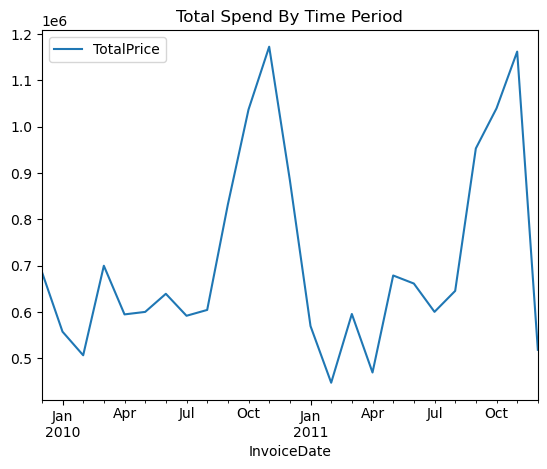

In [24]:
TestObject.plot("spend_by_period")
TestObject.spend_by_period()

,Total Count Of Active Customer ID,Total Count Of New Joiner Customer ID,Total Count Of Retained Customer ID
InvoiceDate,,,
2009-12-01,955,955,0
2010-01-01,720,383,337
2010-02-01,774,376,398
2010-03-01,1057,443,614
2010-04-01,942,294,648
2010-05-01,966,254,712
2010-06-01,1041,270,771
2010-07-01,928,186,742
2010-08-01,911,162,749


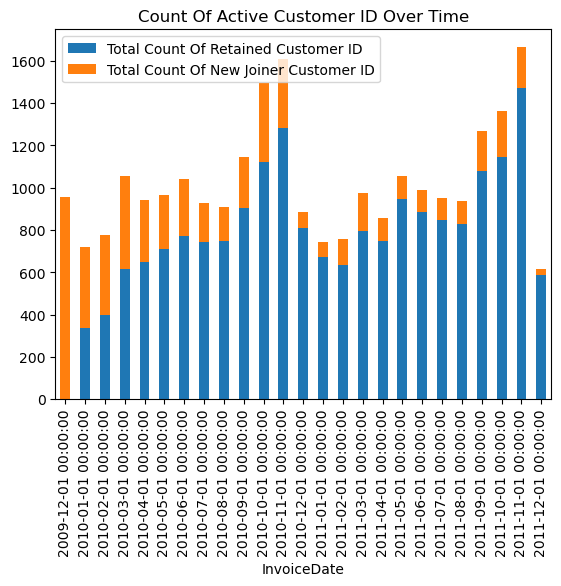

In [25]:
TestObject.plot("total_active_customers_by_period")
TestObject.total_active_customers_by_period()

Here we can ignore the first few periods as it is likely the dataset is just a continuation of previous year data so the "new" customers seen are not true new customers but just existing who haven't yet bought within the data sample period. The no of new joiners does appear to have a seasonal pattern with more new customers joining towards the year end holiday season of Q4

Just for contrast, it is important to note that Time Granularity matters as the picture looks slightly different depending on timescale such as the coarser but easier to view Quarterly basis

,Total Count Of Active Customer ID,Total Count Of New Joiner Customer ID,Total Count Of Retained Customer ID
InvoiceDate,,,
2009-10-01,955,955,0
2010-01-01,1805,1202,603
2010-04-01,2047,818,1229
2010-07-01,2060,591,1469
2010-10-01,2670,778,1892
2011-01-01,1776,374,1402
2011-04-01,1991,325,1666
2011-07-01,2161,397,1764
2011-10-01,2561,441,2120


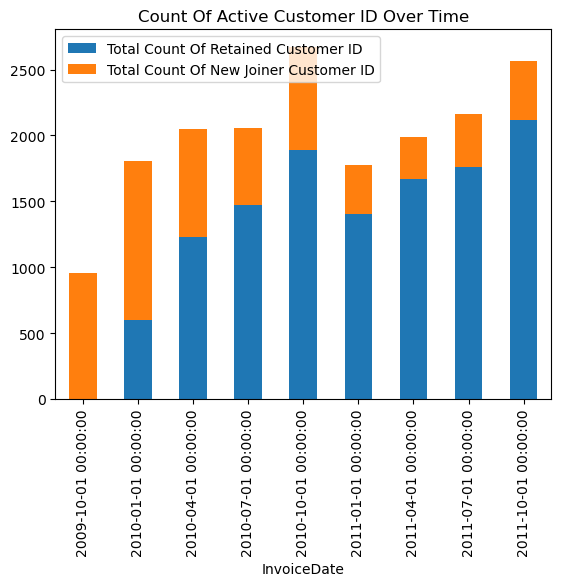

In [26]:
TestObjectByQtr=CustRetAnalysisObj(OLR2_transaction_data,"Invoice",
                  "Transaction Id",
                  "Customer ID",
                  "InvoiceDate",
                  "TotalPrice",
                  "QS")

TestObjectByQtr.plot("total_active_customers_by_period")
TestObjectByQtr.total_active_customers_by_period()

In [27]:
#For the rest of the demo, let's return to mth by mth granularity
TestObject.customer_by_earliest_and_latest_transaction()

,Customer ID,CohortJoinPeriod,Last Recent Order Period
0,12346.0,2009-12-01,2011-01-01
1,12347.0,2010-10-01,2011-12-01
2,12348.0,2010-09-01,2011-09-01
3,12349.0,2010-04-01,2011-11-01
4,12350.0,2011-02-01,2011-02-01
...,...,...,...
5876,18283.0,2010-02-01,2011-12-01
5877,18284.0,2010-10-01,2010-10-01
5878,18285.0,2010-02-01,2010-02-01
5879,18286.0,2009-12-01,2010-08-01


## 6.Cohort Analysis

Rather than just looking at the numbers within the context of the no of New vs Retained, a more important metric is the rate at which customers are leaving. This is what a Cohort chart shows where customers are grouped by a certain criteria and tracked over time to see how often they continue to transact after their first transaction

### 6.1 Cohort Retention By Join Period By Time-Step

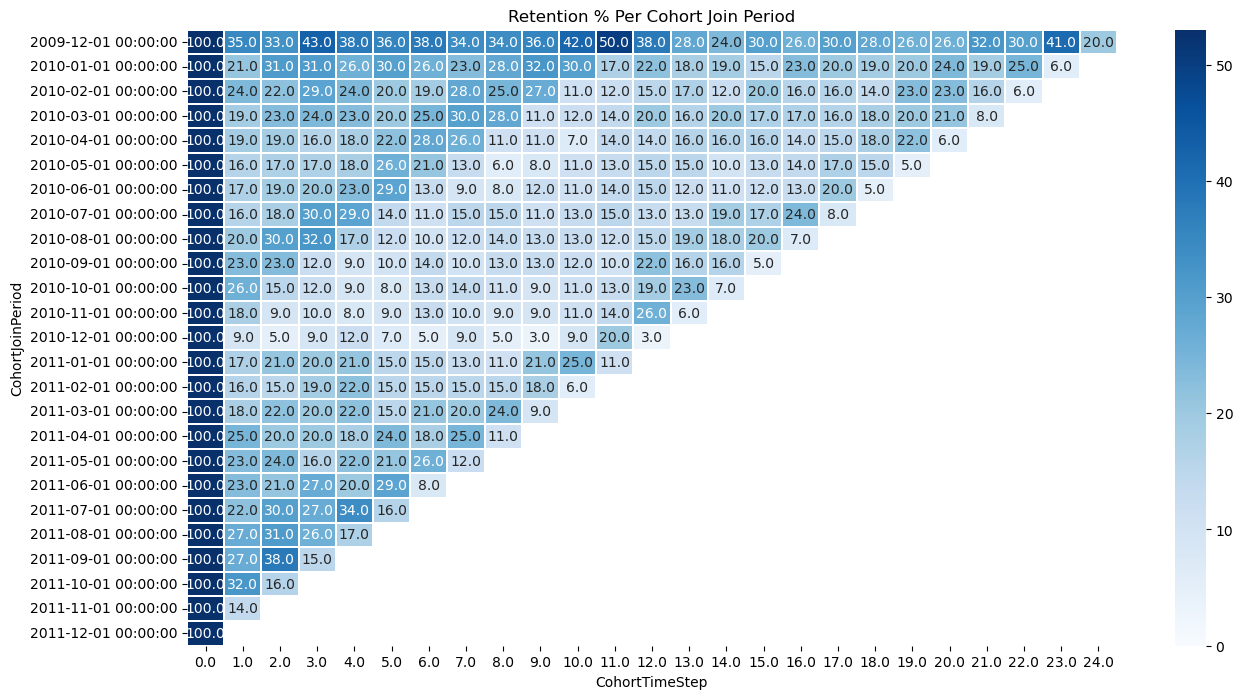

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
CohortJoinPeriod,,,,,,,,,,,,,,,,,,,,,
2009-12-01,100.0,35.0,33.0,43.0,38.0,36.0,38.0,34.0,34.0,36.0,...,30.0,26.0,30.0,28.0,26.0,26.0,32.0,30.0,41.0,20.0
2010-01-01,100.0,21.0,31.0,31.0,26.0,30.0,26.0,23.0,28.0,32.0,...,15.0,23.0,20.0,19.0,20.0,24.0,19.0,25.0,6.0,NaN
2010-02-01,100.0,24.0,22.0,29.0,24.0,20.0,19.0,28.0,25.0,27.0,...,20.0,16.0,16.0,14.0,23.0,23.0,16.0,6.0,NaN,NaN
2010-03-01,100.0,19.0,23.0,24.0,23.0,20.0,25.0,30.0,28.0,11.0,...,17.0,17.0,16.0,18.0,20.0,21.0,8.0,NaN,NaN,NaN
2010-04-01,100.0,19.0,19.0,16.0,18.0,22.0,28.0,26.0,11.0,11.0,...,16.0,14.0,15.0,18.0,22.0,6.0,NaN,NaN,NaN,NaN
2010-05-01,100.0,16.0,17.0,17.0,18.0,26.0,21.0,13.0,6.0,8.0,...,13.0,14.0,17.0,15.0,5.0,NaN,NaN,NaN,NaN,NaN
2010-06-01,100.0,17.0,19.0,20.0,23.0,29.0,13.0,9.0,8.0,12.0,...,12.0,13.0,20.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,100.0,16.0,18.0,30.0,29.0,14.0,11.0,15.0,15.0,11.0,...,17.0,24.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,100.0,20.0,30.0,32.0,17.0,12.0,10.0,12.0,14.0,13.0,...,20.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
TestObject.plot("cohort_by_acquisition_period")
TestObject.cohort_by_acquisition_period()


In [29]:
#the same function can be called with an additional argument of "abs" to show absolute count of customers rather than % change
TestObject.cohort_by_acquisition_period("abs")

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
CohortJoinPeriod,,,,,,,,,,,,,,,,,,,,,
2009-12-01,955.0,337.0,319.0,406.0,363.0,343.0,360.0,327.0,321.0,346.0,...,289.0,251.0,289.0,270.0,248.0,244.0,301.0,291.0,389.0,188.0
2010-01-01,383.0,79.0,119.0,117.0,101.0,115.0,99.0,88.0,107.0,122.0,...,58.0,90.0,76.0,71.0,75.0,93.0,74.0,94.0,22.0,NaN
2010-02-01,376.0,89.0,84.0,109.0,92.0,75.0,72.0,107.0,95.0,103.0,...,75.0,60.0,61.0,54.0,86.0,86.0,61.0,22.0,NaN,NaN
2010-03-01,443.0,84.0,102.0,107.0,103.0,90.0,109.0,134.0,122.0,48.0,...,75.0,77.0,69.0,78.0,89.0,94.0,35.0,NaN,NaN,NaN
2010-04-01,294.0,57.0,57.0,48.0,54.0,66.0,81.0,77.0,31.0,32.0,...,46.0,41.0,44.0,53.0,66.0,17.0,NaN,NaN,NaN,NaN
2010-05-01,254.0,40.0,43.0,44.0,45.0,65.0,54.0,32.0,15.0,21.0,...,32.0,35.0,42.0,39.0,12.0,NaN,NaN,NaN,NaN,NaN
2010-06-01,270.0,47.0,51.0,55.0,62.0,77.0,34.0,24.0,22.0,32.0,...,33.0,36.0,55.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,186.0,29.0,34.0,55.0,54.0,26.0,21.0,27.0,27.0,21.0,...,32.0,44.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,162.0,33.0,48.0,52.0,28.0,19.0,16.0,20.0,22.0,21.0,...,32.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The "spend" argument calculates the "absolute" total spend in dollar terms by the cohorts across time steps...

In [30]:
TestObject.cohort_by_acquisition_period("spend")

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
CohortJoinPeriod,,,,,,,,,,,,,,,,,,,,,
2009-12-01,686654.0,395426.0,296802.0,379654.0,306886.0,305954.0,302858.0,313503.0,332499.0,392636.0,...,256994.0,163344.0,286620.0,280294.0,254570.0,274326.0,376913.0,415966.0,448001.0,163891.0
2010-01-01,161893.0,39134.0,51120.0,57729.0,58860.0,61177.0,52108.0,48190.0,60604.0,74792.0,...,31078.0,49939.0,40971.0,47812.0,42713.0,59233.0,59964.0,58715.0,8826.0,NaN
2010-02-01,170435.0,33367.0,54886.0,53396.0,44025.0,39778.0,40163.0,51344.0,53038.0,54936.0,...,38058.0,30057.0,33408.0,25526.0,45507.0,46047.0,38698.0,11148.0,NaN,NaN
2010-03-01,235467.0,50008.0,51969.0,64791.0,50453.0,56065.0,65617.0,81629.0,76825.0,35245.0,...,31838.0,42854.0,50034.0,47470.0,57507.0,62626.0,17308.0,NaN,NaN,NaN
2010-04-01,125101.0,19036.0,20714.0,30118.0,22310.0,30847.0,35241.0,32775.0,15337.0,17698.0,...,22476.0,17874.0,19424.0,32173.0,30079.0,4943.0,NaN,NaN,NaN,NaN
2010-05-01,110770.0,13674.0,14182.0,12853.0,16861.0,31326.0,23404.0,13774.0,5883.0,7238.0,...,14717.0,22224.0,17739.0,15938.0,3423.0,NaN,NaN,NaN,NaN,NaN
2010-06-01,131828.0,16117.0,22606.0,25902.0,35064.0,48562.0,25466.0,17279.0,23881.0,28536.0,...,18728.0,38487.0,28103.0,4462.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,75378.0,8397.0,13809.0,25008.0,28923.0,15837.0,9119.0,10521.0,10427.0,9996.0,...,15718.0,22697.0,7183.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,61159.0,13830.0,23149.0,23545.0,22406.0,5433.0,5307.0,7288.0,9863.0,9839.0,...,19853.0,5620.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 6.2 Cohort Retention By Customer Attribute By Time-Step

Although cohort by joining period provides a useful starting point, it may be more meaningful to analyse the customer transactional behaviors by the demographic characteristics which is what the next function does

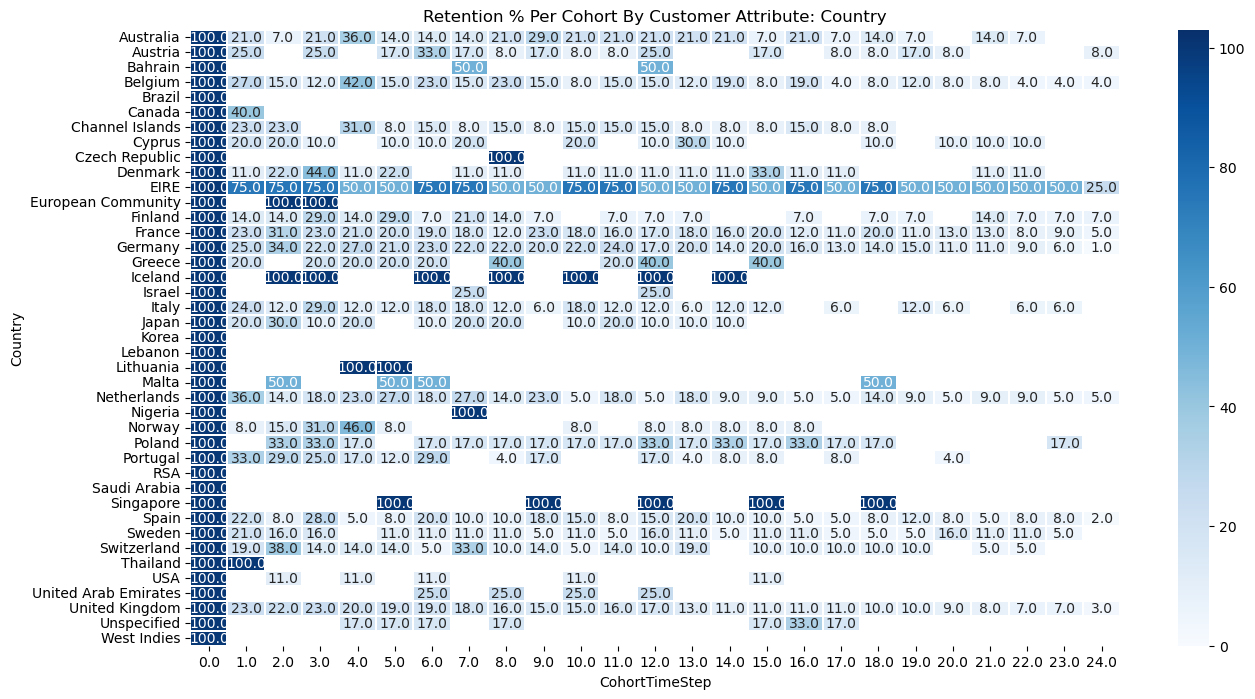

In [31]:
TestObject.plot("cohort_by_customer_attr",CustomerByCountry,"Country")

In [32]:
TestObject.cohort_by_customer_attr(CustomerByCountry,"Country")

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
Country,,,,,,,,,,,,,,,,,,,,,
Australia,100.0,21.0,7.0,21.0,36.0,14.0,14.0,14.0,21.0,29.0,...,7.0,21.0,7.0,14.0,7.0,NaN,14.0,7.0,NaN,NaN
Austria,100.0,25.0,NaN,25.0,NaN,17.0,33.0,17.0,8.0,17.0,...,17.0,NaN,8.0,8.0,17.0,8.0,NaN,NaN,NaN,8.0
Bahrain,100.0,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Belgium,100.0,27.0,15.0,12.0,42.0,15.0,23.0,15.0,23.0,15.0,...,8.0,19.0,4.0,8.0,12.0,8.0,8.0,4.0,4.0,4.0
Brazil,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Canada,100.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Channel Islands,100.0,23.0,23.0,NaN,31.0,8.0,15.0,8.0,15.0,8.0,...,8.0,15.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
Cyprus,100.0,20.0,20.0,10.0,NaN,10.0,10.0,20.0,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,10.0,10.0,10.0,NaN,NaN
Czech Republic,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Similarly as per before with cohort by acquisition period, the same table can be generated with absolute counts rather than percentages by appending the "abs" term

In [33]:
TestObject.cohort_by_customer_attr(CustomerByCountry,"Country","abs")

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
Country,,,,,,,,,,,,,,,,,,,,,
Australia,14.0,3.0,1.0,3.0,5.0,2.0,2.0,2.0,3.0,4.0,...,1.0,3.0,1.0,2.0,1.0,NaN,2.0,1.0,NaN,NaN
Austria,12.0,3.0,NaN,3.0,NaN,2.0,4.0,2.0,1.0,2.0,...,2.0,NaN,1.0,1.0,2.0,1.0,NaN,NaN,NaN,1.0
Bahrain,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Belgium,26.0,7.0,4.0,3.0,11.0,4.0,6.0,4.0,6.0,4.0,...,2.0,5.0,1.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0
Brazil,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Canada,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Channel Islands,13.0,3.0,3.0,NaN,4.0,1.0,2.0,1.0,2.0,1.0,...,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Cyprus,10.0,2.0,2.0,1.0,NaN,1.0,1.0,2.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN
Czech Republic,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In particular for this dataset, it is worth noting that the majority of customers are from the UK so the size of data for other countries may not be representative of the actual behaviors of customers from those locations

### 6.3 Total Average Retention % By Time Step

Another useful overview is to view the aggregated behavior in a retention over time graph....

,Retained Customers By TimeStep,Retention Rate %
CohortTimeStep,,
0.0,5881.0,100.00
1.0,1354.0,23.02
2.0,1317.0,22.39
3.0,1333.0,22.67
4.0,1191.0,20.25
5.0,1117.0,18.99
6.0,1098.0,18.67
7.0,1054.0,17.92
8.0,946.0,16.09


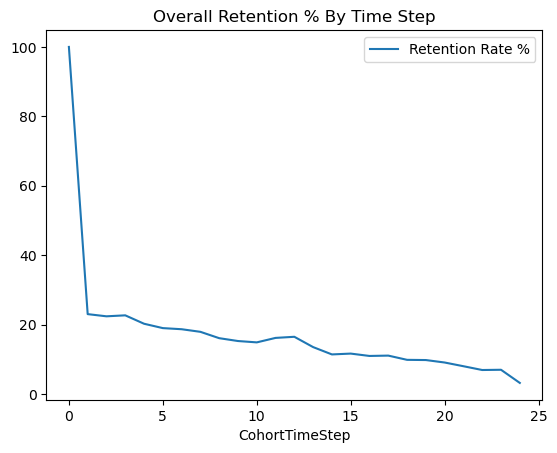

In [34]:
TestObject.plot("overall_retention_by_timestep")
TestObject.overall_retention_by_timestep()

### 6.5 Total No Of Customers By Cumulative Transaction Count

There is also a function that returns the count of customers by total transaction count and no of customers who have at least X transactions 

,Count Of Customers With Trx Freq = X,Count Of Customers With Trx Freq >=X
Frequency,,
1,1781,5881
2,1070,4100
3,661,3030
4,494,2369
5,387,1875
6,281,1488
7,198,1207
8,182,1009
9,150,827


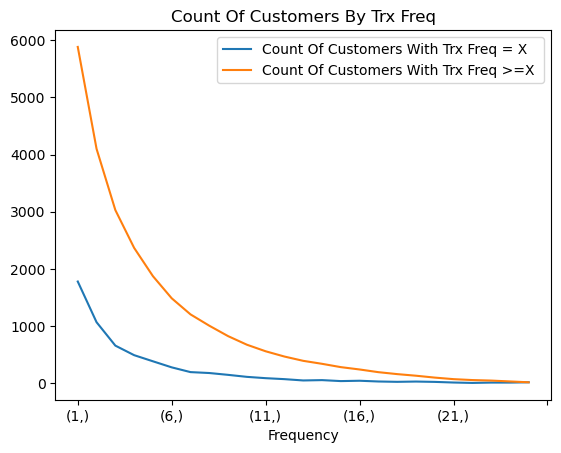

In [35]:
TestObject.plot("count_of_customers_by_min_trx_count")
TestObject.count_of_customers_by_min_trx_count()

### 6.6 Duration Between Transactions

,Mean Time Between Transactions In Months,10th Percentile In Months,Median In Months,90th Percentile In Months
Frequency,,,,
1,NaN,NaN,NaN,NaN
2,3.85,0.98,2.03,9.14
3,3.23,0.98,2.00,7.93
4,2.91,0.98,2.00,6.95
5,2.67,0.98,2.00,5.93
6,2.28,0.98,1.93,4.95
7,2.15,0.98,1.93,4.03
8,1.96,0.98,1.02,3.97
9,1.93,0.98,1.02,3.38


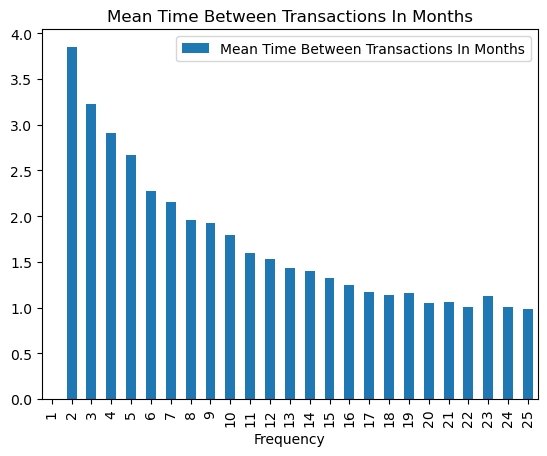

In [36]:
#This function provides the estimate of time between the transactions 
TestObject.plot("time_between_transactions")
TestObject.time_between_transactions()

### 6.7 Cohort Retention By Time-Step Using A Max Inactive Period Assumption

From the earlier Cohort Retention % by Join Period , it is clear that the steep drop in retention (the elbow) happens within the first month itself. Given that the data-set is limited (only 1 year) , a different approach to estimating retention that is less conservative is to focus on the last transaction only and assume that beyond a certain X threshold, the customer will have churned (ie max period of inactivity before churn estimate)

In [37]:
MaxInactivePeriod=60 #max period of inactivity since the latest/most recent transaction before customer is considered as "churned"

In [38]:
#This gives the Expiry Period upon which the above is built 
TestObject.cohort_by_acquisition_period_by_inactive_period(MaxInactivePeriod,"ExpiryDateByCustomer")

,Customer ID,CohortJoinPeriod,Last Recent Order Period,Customer Expiry Period
0,12346.0,2009-12-01,2011-01-01,2011-03-02
1,12347.0,2010-10-01,2011-12-01,2012-01-30
2,12348.0,2010-09-01,2011-09-01,2011-10-31
3,12349.0,2010-04-01,2011-11-01,2011-12-31
4,12350.0,2011-02-01,2011-02-01,2011-04-02
...,...,...,...,...
5876,18283.0,2010-02-01,2011-12-01,2012-01-30
5877,18284.0,2010-10-01,2010-10-01,2010-11-30
5878,18285.0,2010-02-01,2010-02-01,2010-04-02
5879,18286.0,2009-12-01,2010-08-01,2010-09-30


In [39]:
# IMPORTANT - this duration in Days will be limited by the granularity selected.... 
TestObject.cohort_by_acquisition_period_by_inactive_period(MaxInactivePeriod)

CohortTimeStep,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CohortJoinPeriod,,,,,,,,,,,,,,,,,,,,,
2009-12-01,100.0,100.0,91.0,91.0,90.0,88.0,87.0,86.0,85.0,84.0,...,74.0,73.0,70.0,69.0,67.0,66.0,63.0,61.0,56.0,47.0
2010-01-01,100.0,100.0,100.0,87.0,85.0,82.0,80.0,79.0,78.0,75.0,...,63.0,60.0,58.0,55.0,52.0,49.0,44.0,35.0,27.0,NaN
2010-02-01,100.0,100.0,100.0,82.0,81.0,78.0,77.0,76.0,74.0,71.0,...,56.0,56.0,52.0,51.0,46.0,42.0,34.0,19.0,NaN,NaN
2010-03-01,100.0,100.0,81.0,81.0,80.0,79.0,76.0,74.0,73.0,69.0,...,54.0,51.0,47.0,45.0,41.0,35.0,24.0,NaN,NaN,NaN
2010-04-01,100.0,100.0,77.0,76.0,75.0,73.0,72.0,69.0,67.0,62.0,...,52.0,48.0,43.0,39.0,35.0,24.0,NaN,NaN,NaN,NaN
2010-05-01,100.0,100.0,76.0,74.0,72.0,70.0,66.0,61.0,57.0,56.0,...,42.0,39.0,34.0,28.0,18.0,NaN,NaN,NaN,NaN,NaN
2010-06-01,100.0,100.0,73.0,71.0,69.0,65.0,61.0,56.0,54.0,54.0,...,39.0,33.0,29.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,100.0,100.0,72.0,71.0,68.0,61.0,56.0,54.0,54.0,52.0,...,39.0,33.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,100.0,100.0,68.0,67.0,64.0,59.0,57.0,57.0,56.0,54.0,...,32.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


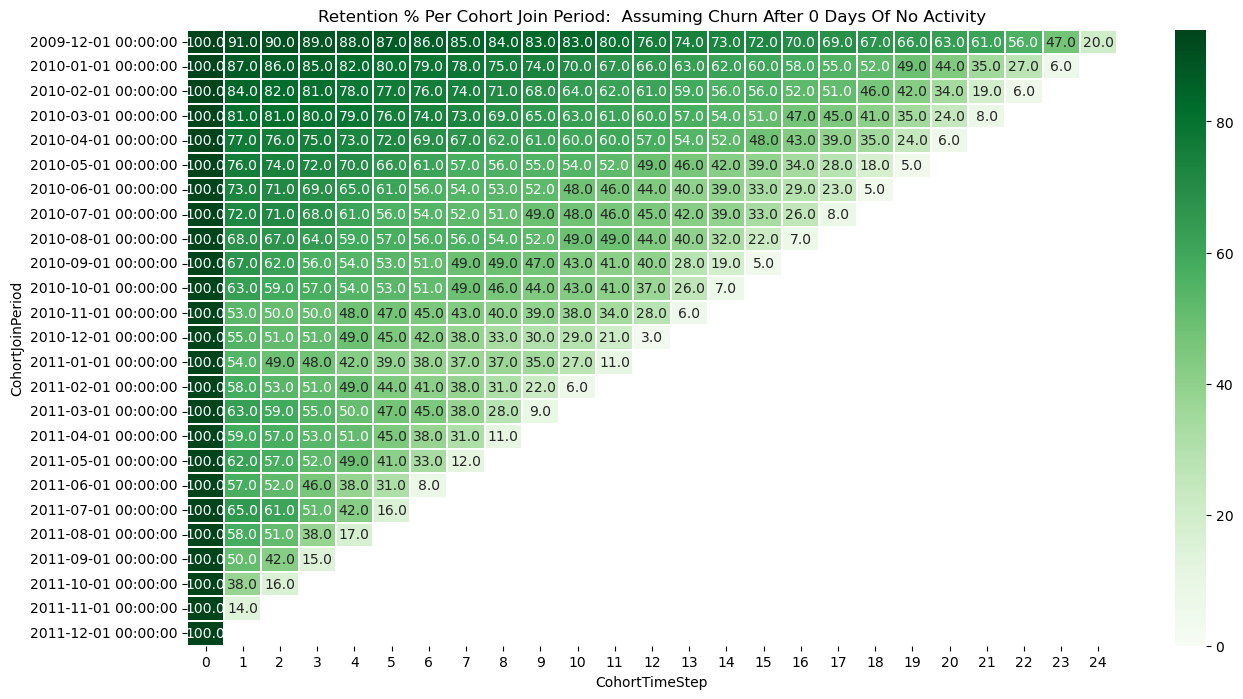

In [40]:
TestObject.plot("cohort_by_acquisition_period_by_inactive_period",MaxInactivePeriod)

In [41]:
TestObject.cohort_by_acquisition_period_by_inactive_period(MaxInactivePeriod,"abs")

CohortTimeStep,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CohortJoinPeriod,,,,,,,,,,,,,,,,,,,,,
2009-12-01,955.0,955.0,866.0,866.0,859.0,841.0,833.0,825.0,814.0,804.0,...,709.0,697.0,671.0,656.0,641.0,627.0,605.0,581.0,535.0,447.0
2010-01-01,383.0,383.0,383.0,333.0,324.0,313.0,308.0,304.0,298.0,289.0,...,243.0,231.0,223.0,210.0,199.0,186.0,169.0,135.0,103.0,NaN
2010-02-01,376.0,376.0,376.0,307.0,304.0,294.0,288.0,285.0,278.0,268.0,...,212.0,209.0,194.0,190.0,173.0,158.0,129.0,73.0,NaN,NaN
2010-03-01,443.0,443.0,359.0,357.0,353.0,348.0,338.0,329.0,322.0,304.0,...,239.0,227.0,208.0,200.0,182.0,155.0,107.0,NaN,NaN,NaN
2010-04-01,294.0,294.0,226.0,222.0,220.0,216.0,212.0,203.0,196.0,183.0,...,153.0,142.0,126.0,114.0,102.0,72.0,NaN,NaN,NaN,NaN
2010-05-01,254.0,254.0,194.0,189.0,184.0,177.0,168.0,154.0,146.0,141.0,...,107.0,98.0,86.0,71.0,45.0,NaN,NaN,NaN,NaN,NaN
2010-06-01,270.0,270.0,196.0,191.0,187.0,176.0,165.0,152.0,145.0,145.0,...,104.0,89.0,79.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,186.0,186.0,134.0,132.0,126.0,114.0,105.0,100.0,100.0,96.0,...,72.0,62.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,162.0,162.0,110.0,108.0,104.0,96.0,93.0,93.0,91.0,87.0,...,52.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some judgement must be applied in interpreting the output above but it provides an alternative means to estimating retention

## 7. Recency, Frequency & Monetary RFM Analysis

,Count Of Customers With Trx Freq = X,Count Of Customers With Trx Freq >=X
Frequency,,
1,1781,5881
2,1070,4100
3,661,3030
4,494,2369
5,387,1875
6,281,1488
7,198,1207
8,182,1009
9,150,827


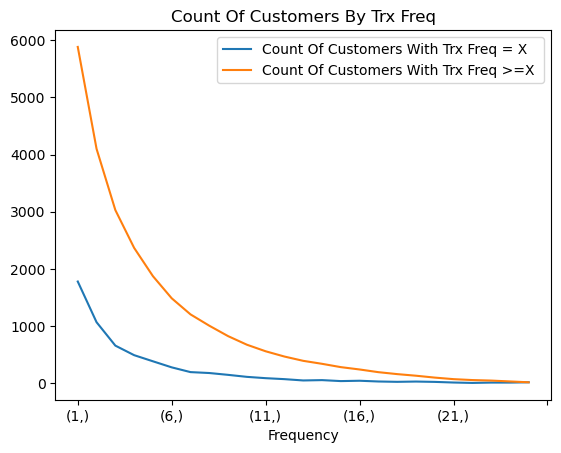

In [42]:
TestObject.plot("count_of_customers_by_min_trx_count")
TestObject.count_of_customers_by_min_trx_count()

,Mean Time Between Transactions In Months,10th Percentile In Months,Median In Months,90th Percentile In Months
Frequency,,,,
1,NaN,NaN,NaN,NaN
2,3.85,0.98,2.03,9.14
3,3.23,0.98,2.00,7.93
4,2.91,0.98,2.00,6.95
5,2.67,0.98,2.00,5.93
6,2.28,0.98,1.93,4.95
7,2.15,0.98,1.93,4.03
8,1.96,0.98,1.02,3.97
9,1.93,0.98,1.02,3.38


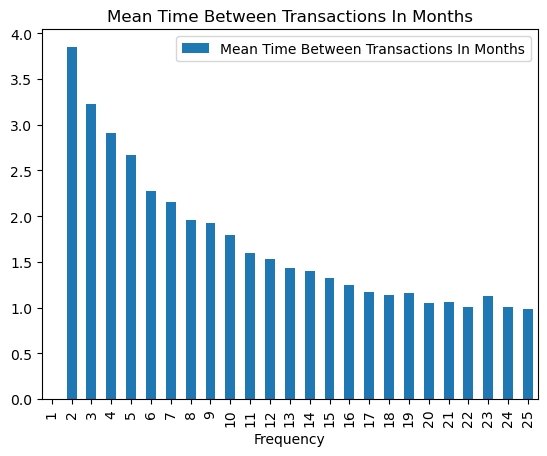

In [43]:
TestObject.plot("time_between_transactions")
TestObject.time_between_transactions()

In [44]:
RFM_table=TestObject.create_RFM_Table()
RFM_table

,Customer ID,Frequency,Frequency Minus 1,Recency In Months,Age In Months,Earliest Order,Most Recent Order,Total Monetary Value,First Time Purchase Value,Average Time Between Orders In Months,Average Monetary Value Per Months
2541,14911.0,25,24,23.93,23.93,2009-12-01,2011-12-01,295972.63,7119.24,1.0,12035.56
2160,14527.0,25,24,23.93,23.93,2009-12-01,2011-12-01,27792.30,5644.28,1.0,922.83
335,12682.0,25,24,23.93,23.93,2009-12-01,2011-12-01,24033.91,1072.95,1.0,956.71
848,13199.0,25,24,23.93,23.93,2009-12-01,2011-12-01,16432.89,138.24,1.0,678.94
5112,17511.0,25,24,23.93,23.93,2009-12-01,2011-12-01,175603.55,8367.81,1.0,6968.16
...,...,...,...,...,...,...,...,...,...,...,...
4119,16501.0,1,0,0.00,12.95,2010-11-01,2010-11-01,1237.23,1237.23,0.0,0.00
734,13084.0,1,0,0.00,15.97,2010-08-01,2010-08-01,122.40,122.40,0.0,0.00
2396,14764.0,1,0,0.00,2.00,2011-10-01,2011-10-01,278.30,278.30,0.0,0.00
736,13086.0,1,0,0.00,12.95,2010-11-01,2010-11-01,439.33,439.33,0.0,0.00


In [45]:
round(RFM_table[["Frequency","Average Time Between Orders In Months","Average Monetary Value Per Months"]].mean(),2)

Frequency                                  4.35
Average Time Between Orders In Months      4.83
Average Monetary Value Per Months        381.95
dtype: float64

<Axes: ylabel='Frequency'>

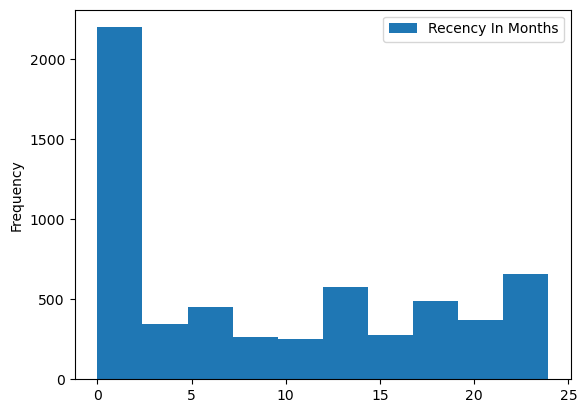

In [46]:
RFM_table[["Recency In Months"]].plot(kind="hist")

<Axes: ylabel='Frequency'>

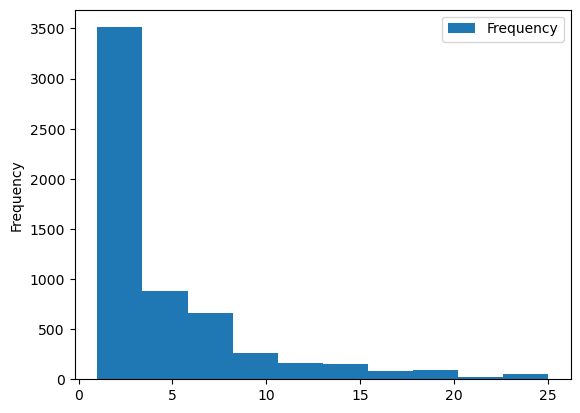

In [47]:
RFM_table[["Frequency"]].plot(kind="hist")

<Axes: ylabel='Frequency'>

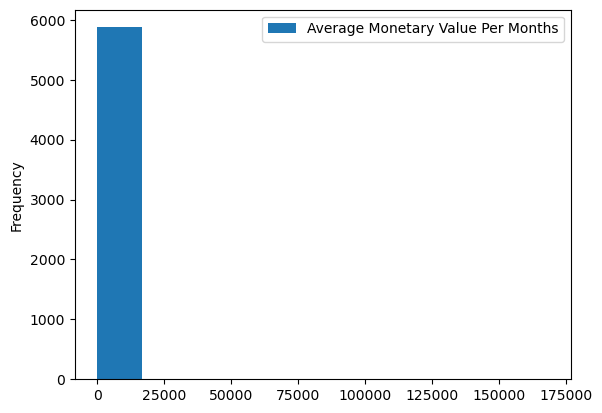

In [48]:
RFM_table[["Average Monetary Value Per Months"]].plot(kind="hist")

Ultimately though ,the same data can be reflected in terms of Recency , Frequency and Monetary Value RFM Analysis but this works best with more granularity timescales (days vs mths)

In [49]:
RFM_table_In_Days=TestObjectInDays.create_RFM_Table()
RFM_table_In_Days

,Customer ID,Frequency,Frequency Minus 1,Recency In Days,Age In Days,Earliest Order,Most Recent Order,Total Monetary Value,First Time Purchase Value,Average Time Between Orders In Days,Average Monetary Value Per Days
2541,14911.0,255,254,737.0,738.0,2009-12-01,2011-12-08,295972.63,733.63,2.91,1162.36
400,12748.0,203,202,735.0,735.0,2009-12-04,2011-12-09,56599.39,220.90,3.64,279.10
2938,15311.0,196,195,738.0,738.0,2009-12-01,2011-12-09,116771.16,823.02,3.78,594.61
5436,17841.0,193,192,736.0,737.0,2009-12-02,2011-12-08,70884.07,530.76,3.84,366.42
2239,14606.0,181,180,735.0,736.0,2009-12-03,2011-12-08,30861.06,215.00,4.09,170.26
...,...,...,...,...,...,...,...,...,...,...,...
2869,15242.0,1,0,0.0,422.0,2010-10-13,2010-10-13,302.04,302.04,0.00,0.00
513,12861.0,1,0,0.0,619.0,2010-03-30,2010-03-30,68.25,68.25,0.00,0.00
1087,13445.0,1,0,0.0,626.0,2010-03-23,2010-03-23,241.90,241.90,0.00,0.00
4497,16886.0,1,0,0.0,456.0,2010-09-09,2010-09-09,134.00,134.00,0.00,0.00


In [50]:
OLR2_transaction_data["InvoiceDate"].max()-OLR2_transaction_data["InvoiceDate"].min()


Timedelta('738 days 05:05:00')

From below - even though these 3 customers bought every month (and hence) were Top by Frequency in the Monthly granularity , there is a difference if we were to zoom down to a higher Daily granularity where 12748 bought on 203 different days vs 12682 who bought every month but only on 48 different day

In [51]:
RFM_table[RFM_table['Customer ID'].isin([12748.0,14527.0,12682.0])]

,Customer ID,Frequency,Frequency Minus 1,Recency In Months,Age In Months,Earliest Order,Most Recent Order,Total Monetary Value,First Time Purchase Value,Average Time Between Orders In Months,Average Monetary Value Per Months
2160,14527.0,25,24,23.93,23.93,2009-12-01,2011-12-01,27792.30,5644.28,1.0,922.83
335,12682.0,25,24,23.93,23.93,2009-12-01,2011-12-01,24033.91,1072.95,1.0,956.71
400,12748.0,25,24,23.93,23.93,2009-12-01,2011-12-01,56599.39,1851.51,1.0,2281.16


In [52]:
RFM_table_In_Days[RFM_table_In_Days['Customer ID'].isin([12748.0,14527.0,12682.0])]

,Customer ID,Frequency,Frequency Minus 1,Recency In Days,Age In Days,Earliest Order,Most Recent Order,Total Monetary Value,First Time Purchase Value,Average Time Between Orders In Days,Average Monetary Value Per Days
400,12748.0,203,202,735.0,735.0,2009-12-04,2011-12-09,56599.39,220.90,3.64,279.10
2160,14527.0,121,120,735.0,737.0,2009-12-02,2011-12-07,27792.30,923.79,6.14,223.90
335,12682.0,48,47,735.0,738.0,2009-12-01,2011-12-06,24033.91,426.30,15.70,502.29
